In [232]:
# jupyter notebook 同时输出多行
import import_ipynb
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## for data
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from pyecharts.charts import Bar, Line
from pyecharts import options as opts

# sns.set()

## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.decomposition import PCA


## for explainer
# from lime import lime_tabular

#jupyter notebook绘图设置
%matplotlib inline
# %config InlineBackend.figure_format="retina"

#解决中文显示问题
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 不要发出警告
import warnings
warnings.filterwarnings('ignore') 
# 在画图的代码后面加上分号 ; 也可以不发出警告

In [233]:
## 读取数据
df = pd.read_excel('raw_data/腹泻病个案信息一览2017-2018.xlsx',
                   sheet_name=0,
                   engine='openpyxl')
print(df.shape)

df["性别"] = df["性别"].map(lambda x: x.strip())
df["性别"] = df["性别"].map(lambda x: "Male" if x =="男" or x=="男性" else "Female")
df.tail()

(38168, 107)


,区县,医院,病例编号,初(复)诊,性别,出生年月,age,户籍,省,详细地址,...,细菌检测结果初次录入时间,细菌检测结果修订时间,样本接收时间(细菌),病毒结果,Lab备注,病毒检测结果初次录入时间,病毒检测结果修订时间,样本接收时间(病毒),Unnamed: 105,Unnamed: 106
38163,青浦区,复旦大学附属中山医院青浦分院,11801201809647,初诊,Male,1940-11,77,本市常住,上海市,上海市青浦区重固镇,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38164,青浦区,复旦大学附属中山医院青浦分院,11801201809646,初诊,Male,1997-11,20,本市外来（含港澳台）,上海市,上海市青浦区赵巷镇,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38165,青浦区,复旦大学附属中山医院青浦分院,11801201809645,初诊,Female,1995-01,23,本市外来（含港澳台）,上海市,上海市青浦区盈浦街道,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38166,青浦区,复旦大学附属中山医院青浦分院,11801201809644,初诊,Male,1984-09,33,本市外来（含港澳台）,上海市,上海市青浦区香花桥街道,...,NaN,NaN,NaN,阴性,NaN,2018-07-30,2018-07-30,NaN,NaN,NaN
38167,青浦区,复旦大学附属中山医院青浦分院,11801201809643,初诊,Female,1973-03,45,本市外来（含港澳台）,上海市,上海市青浦区赵巷镇,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Analysis
1. 删除缺失字段为 100% 的column
2. 删除和分类无关的列

In [234]:
# 可视化查询缺失值
# msno.matrix(df,figsize=(30,8))
# p = msno.matrix(df,figsize=(40,12),labels=True)
# p.figure.savefig('D:\Dropbox\论文\图片\missing_data.pdf')

# 查看数据类型
df.dtypes

区县               object
医院               object
病例编号              int64
初(复)诊            object
性别               object
                 ...   
病毒检测结果初次录入时间     object
病毒检测结果修订时间       object
样本接收时间(病毒)      float64
Unnamed: 105    float64
Unnamed: 106    float64
Length: 107, dtype: object

In [235]:
columns = []
## 显示缺失字段的比例
print("\n字段数据缺失比例")
for col in df.columns:
    ratio = df[col].isnull().sum()/len(df)*100
    print(f"{col:25s} {ratio:3.0f} %")
    # 把缺失比例为 98% 的列删除
    if ratio >= 98:
        pass
    else:
        columns.append(col)

print("\n更新后字段数据缺失比例")
df = df[columns]
for col in df.columns:
    ratio = df[col].isnull().sum()/len(df)*100
    print(f"{col:25s} {ratio:3.0f} %")


字段数据缺失比例
区县                          0 %
医院                          0 %
病例编号                        0 %
初(复)诊                      43 %
性别                          0 %
出生年月                        0 %
age                         0 %
户籍                          0 %
省                           1 %
详细地址                       14 %
职业                          0 %
就诊日期                        0 %
就诊日期1                       0 %
发病日期                        0 %
首发症状                       17 %
其他首发症状                    100 %
发热                          0 %
体温                         83 %
脱水                          0 %
脉搏                         99 %
收缩压                        99 %
舒张压                        99 %
腹胀                          0 %
恶心                          0 %
里急后重                        0 %
肠鸣音亢进                       0 %
腹痛                          0 %
腹痛性质                       48 %
腹痛部位                       48 %
呕吐                          0 %
呕吐频次                       76 

## 提取所需列

In [236]:
# 把所需要的列提取出来 
X = ["区县","性别","age","户籍", "职业", "首发症状", "发热","体温","脱水",
     "腹胀","恶心","里急后重","肠鸣音亢进","腹痛","腹痛性质","腹痛部位","呕吐","呕吐频次","呕吐在腹泻___发生","持续天数",
     "腹泻","腹泻量","腹泻频次","腹泻天数","腹泻性质","神经症状","中毒症状","其他症状","近6个月有无肠道疾病既往史",
    "发病前五天内是否有不洁饮食史","食品名称","食物分类","进餐地点","发病前5天内是否有不洁饮水史","发病前5天内周边有无类似腹泻病例","疑似病例人数",
    "发病前5天内是否有聚餐史","发病前一周是否外出","是否家中饲养或接触过宠物","就诊前是否服用过抗生素",
    "诊断","诊断类型","临床处理","本次就诊是否给予抗生素","抗生素名称.1","是否采集","采样类型"]
y = ["细菌结果"]
data = df[X + y]

# 不知道为什么这里报错了，先 pass
# # 简单的预处理: 把空格去掉
# for column in X:
#     if df[column].dtypes == "object":
#         print(column)
#         df[column] = df[column].map(lambda x: x.strip())


# 把提取出来的数据存入新的 `tsv` 文件
data_file = "data\腹泻_new.tsv"
data.to_csv(data_file, sep="\t", encoding="utf-8")

In [237]:
# 读取文件
data_file = "data\腹泻_new.tsv"
df = pd.read_csv(data_file, sep="\t", index_col=0, encoding="utf-8")
df.head()

,区县,性别,age,户籍,职业,首发症状,发热,体温,脱水,腹胀,...,是否家中饲养或接触过宠物,就诊前是否服用过抗生素,诊断,诊断类型,临床处理,本次就诊是否给予抗生素,抗生素名称.1,是否采集,采样类型,细菌结果
0,闵行区,Male,28,本市外来（含港澳台）,干部职员,腹泻,有,37.0,无,有,...,否,否,慢性肠胃炎,临床诊断,NaN,是,其他(阿米卡星),是,食源性采样,NaN
1,闵行区,Male,59,本市外来（含港澳台）,医务人员,"腹痛,腹泻",无,NaN,无,有,...,否,否,胃肠炎,实验室诊断,NaN,否,NaN,是,食源性采样,"其他弯曲菌,小肠结肠耶尔森菌"
2,闵行区,Female,63,本市常住,离退人员,腹泻,无,NaN,无,无,...,否,否,急性胃肠炎,临床诊断,口服用药,否,NaN,否,未采样,NaN
3,闵行区,Male,81,本市常住,离退人员,腹泻,无,37.0,无,无,...,否,否,急性胃肠炎,临床诊断,口服用药,是,诺氟沙星,否,未采样,NaN
4,闵行区,Female,49,本市常住,干部职员,腹泻,无,NaN,无,无,...,否,否,急性胃肠炎,临床诊断,口服用药,否,NaN,是,腹泻病采样,NaN


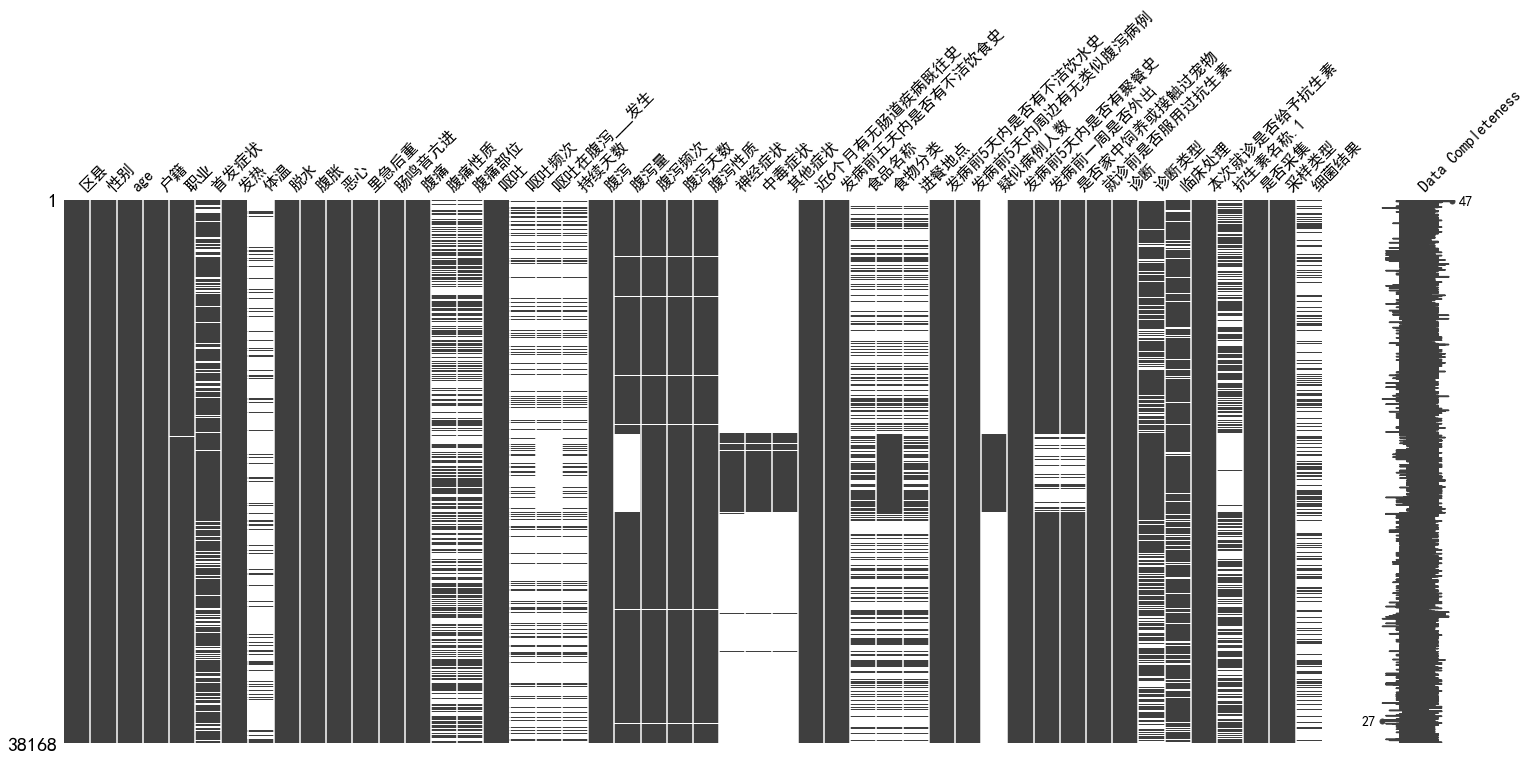

In [238]:
# 可视化查询缺失值
p = msno.matrix(df,figsize=(25,10),labels=True)
p.figure.savefig('D:\Dropbox\论文\图片\missing_data.pdf',bbox_inches = 'tight')

## 区县分布，性别分布，年龄分布，户籍分布，职业分布

In [239]:
# pros = df['区县']
# pros_count = pros.value_counts().sort_values(ascending=False)

def val_count(df, column):
    column_count = df[column].value_counts().sort_values(ascending=False)
    return column_count

In [240]:
from pyecharts.charts import Bar
from pyecharts import options as opts

# 该函数的输入是一个 Series 格式的数据
def bar_dist(data, title):
    """
    --- input
    data: data count (Type: pd.Series)
    title: title of the figrue (Type: String)
    --- return
    bar: pyecharts object to show
    """
    # 把 index 转换为列表
    x = data.index.tolist()
    y = data.tolist()
    bar = (
        Bar()
        .add_xaxis(x)
        .add_yaxis("就医人数", y, gap="0%", itemstyle_opts=opts.ItemStyleOpts(opacity="0.5"),
                   label_opts=opts.LabelOpts(rotate=0, font_size=10))
        # 全局配置项
        .set_global_opts(title_opts=opts.TitleOpts(title=title),
                         xaxis_opts=opts.AxisOpts(name=data.name, 
                                                  name_location="center",
                                                  name_gap = 35,
                                                  axislabel_opts=opts.LabelOpts(rotate=25, font_size=10)),
                         yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(font_size=10)),
                         legend_opts=opts.LegendOpts(is_show=False))
    )
    return bar

# columns = ["区县","性别", "户籍","职业"]
columns = ["性别"]

f = []
for i, column in enumerate(columns):
    count = val_count(df, column)
    # f.append(bar_dist(count, title=f"各{column}就医人数分布"))
    f.append(bar_dist(count, title=""))
    f[i].render_notebook()


In [241]:
## 直方图
# 准备数据
import matplotlib.mlab as mlab
def data_hist(df, column, interval):
    """
    interval(int): 区间
    output: 两个列表 x_axis, count
    """
    # x 轴上的每一个点
    x_axis = [
        df[column].min() + i * interval
        for i in range(int(df[column].max() - df[column].min()) // interval + 1)
    ]
    # 统计每个间隔内的人数
    count = [
        len(df[(x_axis[i] <= df[column]) & (df[column] < x_axis[i + 1])])
        for i in range(len(x_axis) - 1)
    ]
    return x_axis, count


# 绘制图像
# 输入两个列表
def figure_hist(x_axis, count, title=""):
    bar = (
        Bar()
        .add_xaxis(x_axis)
        .add_yaxis("就医人数", count, gap="0%", itemstyle_opts=opts.ItemStyleOpts(opacity="0.5"),
                   label_opts=opts.LabelOpts(rotate=0, font_size=10))
        # 全局配置项
        .set_global_opts(title_opts=opts.TitleOpts(title=title),
                         xaxis_opts=opts.AxisOpts(name=df[column].name, 
                                                  name_location="center",
                                                  name_gap = 20,
                                                  axislabel_opts=opts.LabelOpts(rotate=0, font_size=10)),
                         yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(font_size=10)),
                         legend_opts=opts.LegendOpts(is_show=False))
    )
    return bar


## 绘制图像
column = "age"
age_axis, count= data_hist(df, column, 3)
f1 = figure_hist(age_axis, count, "就医患者年龄分布直方图")
f1.render_notebook()

<Figure size 936x576 with 0 Axes>

[None, None, None, None, None, None, None, None, None, None, None, None, None]

Text(0.5, 0, 'Age')

Text(0, 0.5, 'Density')

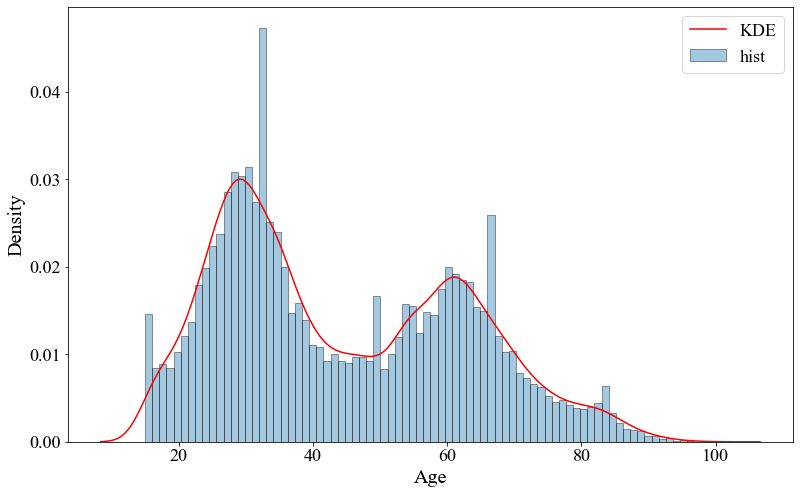

In [242]:
## 直方图查看患者年龄分布
plt.figure(figsize=(13, 8))
x = "age"


p = sns.distplot(df[x], bins=80,hist_kws={'label':'hist', 'edgecolor': 'black'},
                     kde_kws={'color':'red','label':'KDE'},
                 );

#设置图例并且设置图例的字体及大小
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 18,
}
p.legend(prop=font1,loc='best')

#设置坐标刻度值的大小以及刻度值的字体
p.tick_params(labelsize=18)
labels = p.get_xticklabels() + p.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
 
#设置横纵坐标的名称以及对应字体格式
font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 20,
}
p.set_xlabel('Age',font2)
p.set_ylabel('Density',font2)
p.figure.savefig('D:/Dropbox/论文/图片/age.pdf',bbox_inches = 'tight')

<Figure size 504x360 with 0 Axes>

[None, None, None, None, None, None, None, None]

Text(0.5, 0, 'Sex')

Text(0, 0.5, 'Count')

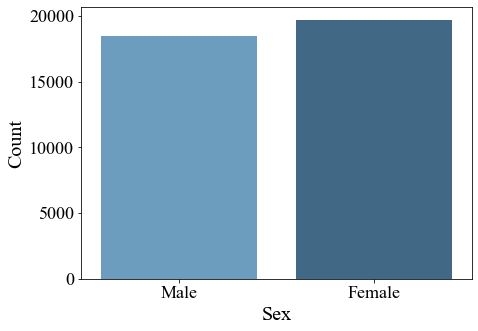

In [243]:
plt.figure(figsize=(7, 5))
p = sns.countplot(x="性别", data=df,palette="Blues_d")

#设置坐标刻度值的大小以及刻度值的字体
p.tick_params(labelsize=18)
labels = p.get_xticklabels() + p.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
 
#设置横纵坐标的名称以及对应字体格式
font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 20,
}
# p.set_xticklabels(['Male','Female'])
p.set_xlabel('Gender',font2)
p.set_ylabel('Count',font2)
p.figure.savefig('D:/Dropbox/论文/图片/sex.pdf',bbox_inches = 'tight')

## 缺失值填充
1. 以"细菌结果"为例，先删除"细菌结果"列为空值的行
2. 对其他列进行缺失值填充：连续数据，分类数据

### 连续数据


In [244]:
df.info()

## 删除"细菌结果"列为空值的行
df.dropna(axis=0, how='any',subset=['细菌结果'], inplace=True)
print(df.shape)

## 缺失值填充
# 1. 连续数据类 --> 均值、众数
# int/flaot：age，体温，呕吐频次，持续天数，腹泻量，腹泻频次，腹泻天数，疑似病例人数
df["age"].fillna(df["age"].mean(), inplace=True)
## 直方图查看患者年龄分布
# x = "age"
# sns.distplot(df[x], bins=50)

df["体温"].fillna(df["体温"].mode()[0], inplace=True)

# "呕吐频次" 与前一列 "呕吐" 的值相关：
# 如果 "呕吐"="无" --> "呕吐频次"=0; 
df.loc[df['呕吐']=="无", '呕吐频次'] = 0
print("呕吐频次列缺失数-1", df['呕吐频次'].isnull().sum())
# 如果 "呕吐"="有"且 "呕吐频次" 为空值--> "呕吐频次"=1
df['呕吐频次'].fillna(1, inplace=True)
print("呕吐频次列缺失数-2", df['呕吐频次'].isnull().sum())
# df['涨跌'].replace([-1,0,1], ['跌','平','涨'], inplace = True) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38168 entries, 0 to 38167
Data columns (total 48 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   区县                38168 non-null  object 
 1   性别                38168 non-null  object 
 2   age               38168 non-null  int64  
 3   户籍                38168 non-null  object 
 4   职业                38067 non-null  object 
 5   首发症状              31524 non-null  object 
 6   发热                38168 non-null  object 
 7   体温                6315 non-null   float64
 8   脱水                38168 non-null  object 
 9   腹胀                38168 non-null  object 
 10  恶心                38168 non-null  object 
 11  里急后重              38168 non-null  object 
 12  肠鸣音亢进             38168 non-null  object 
 13  腹痛                38168 non-null  object 
 14  腹痛性质              19962 non-null  object 
 15  腹痛部位              19990 non-null  object 
 16  呕吐                38168 non-null  object

In [245]:
# “持续天数” 也是和 "呕吐"列有关
# 如果 "呕吐"="无" --> "持续天数"=0; 
df.loc[df['呕吐']=="无", '持续天数'] = 0
print("持续天数列缺失数-1", df['持续天数'].isnull().sum())
# 如果 "呕吐"="有"且 "持续天数" 为空值--> "持续天数"=1
df['持续天数'].fillna(1, inplace=True)
print("持续天数列缺失数-2", df['持续天数'].isnull().sum())

持续天数列缺失数-1 2
持续天数列缺失数-2 0


In [246]:
# "腹泻量","腹泻频次","腹泻天数" 都和 "腹泻"栏的值相关
# 如果 "腹泻" == "无"，则前三列都为 0
columns = ["腹泻量","腹泻频次","腹泻天数"]
for column in columns:  
    df.loc[df['腹泻']=="无", column] = 0
    print(f"{column}缺失数-1", df[column].isnull().sum())
    # 如果 "腹泻" == "有"且 "腹泻量"为空值，腹泻量用均值填充
    df[column].fillna(df[column].mean(), inplace=True)
    print(f"{column}缺失数-2", df[column].isnull().sum())

腹泻量缺失数-1 2661
腹泻量缺失数-2 0
腹泻频次缺失数-1 0
腹泻频次缺失数-2 0
腹泻天数缺失数-1 3
腹泻天数缺失数-2 0


In [247]:
## map 用法
# 1. 使用字典进行映射
# data["gender"] = data["gender"].map({"男":1, "女":0})
# 2. 使用函数
# def gender_map(x):
#     gender = 1 if x == "男" else 0
#     return gender
## 注意这里传入的是函数名，不带括号
# data["gender"] = data["gender"].map(gender_map)

## apply 用法
# apply 方法的作用原理和 map 方法类似，区别在于 apply 能够传入功能更为复杂的函数
# apply 接受的函数可以有多个参数
# def apply_age(x,bias):
#     return x+bias
# #以元组的方式传入额外的参数
# data["age"] = data["age"].apply(apply_age,args=(-3,))

In [248]:
# "疑似病例人数" 与前一列 "发病前5天内周边有无类似腹泻病例" 的值相关
# 先把 "发病前5天内周边有无类似腹泻病例" 列的值处理一下：否 无 是 有
def yes_no(x):
    """
    统一说法:
    否 无 --> 无
    是 有 --> 有
    """
    if x=="否" or x=="无":
        return "无"
    else:
        return "有"
df['发病前5天内周边有无类似腹泻病例'] = df['发病前5天内周边有无类似腹泻病例'].map(yes_no)

# 如果 "发病前5天内周边有无类似腹泻病例"="无" --> "疑似病例人数"=0; 
df.loc[df['发病前5天内周边有无类似腹泻病例']=="无", '疑似病例人数'] = 0
print("疑似病例人数列缺失数-1", df['疑似病例人数'].isnull().sum())
# 如果 "发病前5天内周边有无类似腹泻病例"="有"且 "持续天数" 为空值--> "疑似病例人数"=1
df['疑似病例人数'].fillna(1, inplace=True)
print("疑似病例人数列缺失数-2", df['疑似病例人数'].isnull().sum())

疑似病例人数列缺失数-1 0
疑似病例人数列缺失数-2 0


### 分类数据

In [249]:
# 职业, 首发症状，腹痛性质，腹痛部位，呕吐在腹泻___发生，神经症状，中毒症状，其他症状，食品名称，食物分类，进餐地点
# 发病前一周是否外出，是否家中饲养或接触过宠物，诊断类型，临床处理，抗生素名称.1
# object 栏一般情况下如果没有写，默认为没有，用其他值也不好填
x = ["职业","首发症状","腹痛性质","腹痛部位","呕吐在腹泻___发生","神经症状","中毒症状","其他症状","食品名称",
     "食物分类","进餐地点","发病前一周是否外出","是否家中饲养或接触过宠物","诊断类型","临床处理","抗生素名称.1"]
for column in x:
    df[column].fillna("无", inplace=True)
    
# 需要统一说法的 column：否 无 是 有
x = ["发病前五天内是否有不洁饮食史","发病前5天内是否有不洁饮水史","发病前5天内周边有无类似腹泻病例",
    "发病前5天内是否有聚餐史","发病前一周是否外出","是否家中饲养或接触过宠物","就诊前是否服用过抗生素",
     "本次就诊是否给予抗生素","是否采集"]
for column in x:
    df[column] = df[column].map(yes_no)
    
## 还有一些栏目的值需要做一些调整，例如食物名称和食品分类那一栏
# pass

In [250]:
for col in df.columns:
    ratio = df[col].isnull().sum()/len(df)*100
    print(f"{col:25s} {ratio:3.0f} %")
    
# 检查每一列是否有空值
# df.isnull().any()

区县                          0 %
性别                          0 %
age                         0 %
户籍                          0 %
职业                          0 %
首发症状                        0 %
发热                          0 %
体温                          0 %
脱水                          0 %
腹胀                          0 %
恶心                          0 %
里急后重                        0 %
肠鸣音亢进                       0 %
腹痛                          0 %
腹痛性质                        0 %
腹痛部位                        0 %
呕吐                          0 %
呕吐频次                        0 %
呕吐在腹泻___发生                  0 %
持续天数                        0 %
腹泻                          0 %
腹泻量                         0 %
腹泻频次                        0 %
腹泻天数                        0 %
腹泻性质                        0 %
神经症状                        0 %
中毒症状                        0 %
其他症状                        0 %
近6个月有无肠道疾病既往史               0 %
发病前五天内是否有不洁饮食史              0 %
食品名称                        0 %
食物分类    

In [251]:
# 把缺失值填充完成后的数据存入新的 `tsv` 文件
df_file = "data/fuxie_fillna.tsv"
df.to_csv(df_file, sep="\t", encoding="utf-8")

In [252]:
# 读取文件
df_file = "data/fuxie_fillna.tsv"
df = pd.read_csv(df_file, sep="\t", index_col=0, encoding="utf-8")
df.columns
df.shape

Index(['区县', '性别', 'age', '户籍', '职业', '首发症状', '发热', '体温', '脱水', '腹胀', '恶心',
       '里急后重', '肠鸣音亢进', '腹痛', '腹痛性质', '腹痛部位', '呕吐', '呕吐频次', '呕吐在腹泻___发生',
       '持续天数', '腹泻', '腹泻量', '腹泻频次', '腹泻天数', '腹泻性质', '神经症状', '中毒症状', '其他症状',
       '近6个月有无肠道疾病既往史', '发病前五天内是否有不洁饮食史', '食品名称', '食物分类', '进餐地点',
       '发病前5天内是否有不洁饮水史', '发病前5天内周边有无类似腹泻病例', '疑似病例人数', '发病前5天内是否有聚餐史',
       '发病前一周是否外出', '是否家中饲养或接触过宠物', '就诊前是否服用过抗生素', '诊断', '诊断类型', '临床处理',
       '本次就诊是否给予抗生素', '抗生素名称.1', '是否采集', '采样类型', '细菌结果'],
      dtype='object')

(11600, 48)

In [253]:
# 去除类型为 object 列的空格
obj = df.dtypes[df.dtypes == 'object'].index.tolist()
obj.remove("腹泻性质")
for column in obj:
    print(column)
    df[column] = df[column].astype('object')
    df[column] = df[column].map(lambda x: x.strip())

区县
性别
户籍
职业
首发症状
发热
脱水
腹胀
恶心
里急后重
肠鸣音亢进
腹痛
腹痛性质
腹痛部位
呕吐
呕吐在腹泻___发生
腹泻
神经症状
中毒症状
其他症状
近6个月有无肠道疾病既往史
发病前五天内是否有不洁饮食史
食品名称
食物分类
进餐地点
发病前5天内是否有不洁饮水史
发病前5天内周边有无类似腹泻病例
发病前5天内是否有聚餐史
发病前一周是否外出
是否家中饲养或接触过宠物
就诊前是否服用过抗生素
诊断
诊断类型
临床处理
本次就诊是否给予抗生素
抗生素名称.1
是否采集
采样类型
细菌结果


In [254]:
# 检查每一列是否有空值
df.isnull().any()

区县                  False
性别                  False
age                 False
户籍                  False
职业                  False
首发症状                False
发热                  False
体温                  False
脱水                  False
腹胀                  False
恶心                  False
里急后重                False
肠鸣音亢进               False
腹痛                  False
腹痛性质                False
腹痛部位                False
呕吐                  False
呕吐频次                False
呕吐在腹泻___发生          False
持续天数                False
腹泻                  False
腹泻量                 False
腹泻频次                False
腹泻天数                False
腹泻性质                 True
神经症状                False
中毒症状                False
其他症状                False
近6个月有无肠道疾病既往史       False
发病前五天内是否有不洁饮食史      False
食品名称                False
食物分类                False
进餐地点                False
发病前5天内是否有不洁饮水史      False
发病前5天内周边有无类似腹泻病例    False
疑似病例人数              False
发病前5天内是否有聚餐史        False
发病前一周是否外出           False
是否家中饲养或接触过宠物

## 结果概览

In [ ]:
y = "细菌结果"
# 把细菌结果分为两类：阴性和阳性
df[y] = df[y].map(lambda x: 0 if x == "阴性" else 1)

<Figure size 504x360 with 0 Axes>

[None, None, None, None, None, None, None, None]

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

Text(0.5, 0, '')

Text(0, 0.5, 'Count')

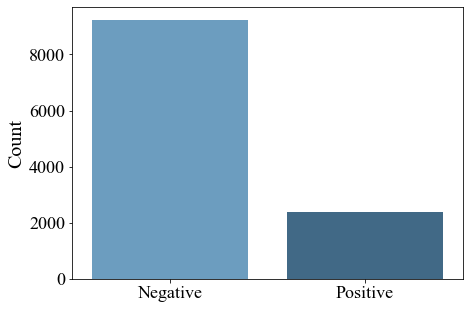

In [257]:
plt.figure(figsize=(7, 5))
p = sns.countplot(x="细菌结果", data=df,palette="Blues_d")

#设置坐标刻度值的大小以及刻度值的字体
p.tick_params(labelsize=18)
labels = p.get_xticklabels() + p.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
 
#设置横纵坐标的名称以及对应字体格式
font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 20,
}
p.set_xticklabels(['Negative','Positive'])
p.set_xlabel('',font2)
# p.set_xlabel('Bacterial infection results',font2)
p.set_ylabel('Count',font2)
p.figure.savefig('D:/Dropbox/论文/图片/label_dist.pdf',bbox_inches = 'tight')

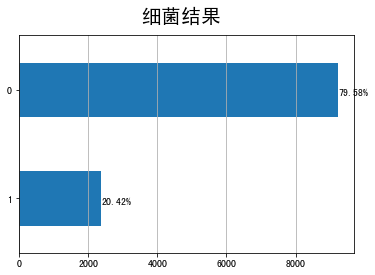

In [124]:
y = "细菌结果"
# 把细菌结果分为两类：阴性和阳性
df[y] = df[y].map(lambda x: 0 if x == "阴性" else 1)

ax = df[y].value_counts().sort_values().plot(kind="barh")
totals = []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
# ax.patches 应该是包含图中的三个柱子
for i in ax.patches:
    # 前面两个参数是在设置文本放置的位置
    ax.text(i.get_width() + .3,
            i.get_y() + .20,
            str(round((i.get_width() / total) * 100, 2)) + '%',
            fontsize=10,
            color='black')
ax.grid(axis="x")
plt.suptitle(y, fontsize=20)
plt.show();


In [125]:
# pyecharts bar 实现
count = val_count(df, y)
f=bar_dist(count, title=f"{df[y].name}")
f.render_notebook()

## 特征选择

### 单因素方差分析与卡方检验
用统计学的手段检测自变量（特征）是否与因变量（标签）相关。

In [156]:
## 连续数据：单因素方差分析
def correlation_anova(x,y,df):
    """
    one-way ANOVA test
    """
    model = smf.ols(x+' ~ '+y, data=df).fit()
    table = sm.stats.anova_lm(model)
    # P 值: 选取 table 表中的 "PR(>F)" 列的第一行的值
    # print(table)
    p = table["PR(>F)"][0]
    # p 值保留三位小数
    coeff, p = None, round(p, 3)
    conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
    print(f"Anova F: the variables {x, y} are", conclusion, "(p-value: "+str(p)+")")
    return p, conclusion

# test function
y, x = "细菌结果", "age"
correlation_anova(x,y,df)

## 对所有连续变量应用单因素方差分析：age，体温
# Index 对象负责管理轴标签、轴名称等元数据，是一个不可修改的、有序的、可以索引的 ndarry 对象
# Index 对象是一个从索引到数据值的映射，当数据是一列时，index 是列索引；
# 当数据是一行数据时，Index 是行索引
# Index --> list: Index.to_list(self) 但是我感觉好像不用转换
obj_columns = df.select_dtypes(include=object).columns.to_list()
cont_columns = [column for column in df.columns if column not in obj_columns]
print(obj_columns)
print("-"*50)
print(cont_columns)

Anova F: the variables ('age', '细菌结果') are Correlated (p-value: 0.0)


(0.0, 'Correlated')

['区县', '性别', '户籍', '职业', '首发症状', '发热', '脱水', '腹胀', '恶心', '里急后重', '肠鸣音亢进', '腹痛', '腹痛性质', '腹痛部位', '呕吐', '呕吐在腹泻___发生', '腹泻', '腹泻性质', '神经症状', '中毒症状', '其他症状', '近6个月有无肠道疾病既往史', '发病前五天内是否有不洁饮食史', '食品名称', '食物分类', '进餐地点', '发病前5天内是否有不洁饮水史', '发病前5天内周边有无类似腹泻病例', '发病前5天内是否有聚餐史', '发病前一周是否外出', '是否家中饲养或接触过宠物', '就诊前是否服用过抗生素', '诊断', '诊断类型', '临床处理', '本次就诊是否给予抗生素', '抗生素名称.1', '是否采集', '采样类型']
--------------------------------------------------
['age', '体温', '呕吐频次', '持续天数', '腹泻量', '腹泻频次', '腹泻天数', '疑似病例人数', '细菌结果']


In [157]:
y = "细菌结果"
cont_p = []
cont_conclusion = []
for column in cont_columns:
    p, conclusion = correlation_anova(column,y,df)
    cont_p.append(p)
    cont_conclusion.append(conclusion)


list_of_tuple = list(zip(cont_p,cont_conclusion))
cont_result = pd.DataFrame(data=list_of_tuple,index=cont_columns,columns=["P Value", "Effective"])
# 设置让列名对齐
cont_result.style.set_properties(**{'text-align': 'left'})

Anova F: the variables ('age', '细菌结果') are Correlated (p-value: 0.0)
Anova F: the variables ('体温', '细菌结果') are Correlated (p-value: 0.0)
Anova F: the variables ('呕吐频次', '细菌结果') are Non-Correlated (p-value: 0.116)
Anova F: the variables ('持续天数', '细菌结果') are Non-Correlated (p-value: 0.234)
Anova F: the variables ('腹泻量', '细菌结果') are Correlated (p-value: 0.0)
Anova F: the variables ('腹泻频次', '细菌结果') are Correlated (p-value: 0.0)
Anova F: the variables ('腹泻天数', '细菌结果') are Correlated (p-value: 0.0)
Anova F: the variables ('疑似病例人数', '细菌结果') are Non-Correlated (p-value: 0.564)
Anova F: the variables ('细菌结果', '细菌结果') are Correlated (p-value: 0.0)


,P Value,Effective
age,0.000000,Correlated
体温,0.000000,Correlated
呕吐频次,0.116000,Non-Correlated
持续天数,0.234000,Non-Correlated
腹泻量,0.000000,Correlated
腹泻频次,0.000000,Correlated
腹泻天数,0.000000,Correlated
疑似病例人数,0.564000,Non-Correlated
细菌结果,0.000000,Correlated


Text(0.5, 0.98, 'Age   vs   Bacterial infection results')

<AxesSubplot:xlabel='age', ylabel='Density'>

<AxesSubplot:xlabel='age', ylabel='Density'>

Text(0.5, 0, 'Age')

Text(0, 0.5, 'Density')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

<AxesSubplot:xlabel='age'>

Text(0.5, 0, 'Age')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '(15.0, 24.0]'),
  Text(1, 0, '(24.0, 28.0]'),
  Text(2, 0, '(28.0, 31.0]'),
  Text(3, 0, '(31.0, 36.0]'),
  Text(4, 0, '(36.0, 43.0]'),
  Text(5, 0, '(43.0, 53.0]'),
  Text(6, 0, '(53.0, 59.0]'),
  Text(7, 0, '(59.0, 63.0]'),
  Text(8, 0, '(63.0, 70.0]'),
  Text(9, 0, '(70.0, 100.0]')])

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

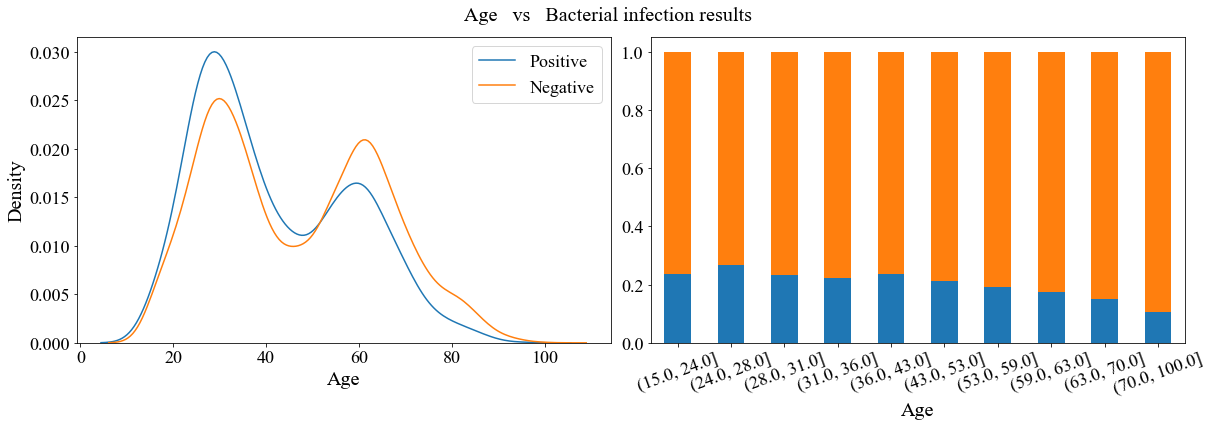

In [204]:
# 可视化
y, x = "细菌结果", "age"
fig, ax = plt.subplots(nrows=1,
                       ncols=2,
                       sharex=False,
                       sharey=False,
                       figsize=(17, 6))



#设置图例并且设置图例的字体及大小
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 18,
}

#设置横纵坐标的名称以及对应字体格式
font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 20,
}

font3 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 23,
}

fig.suptitle("Age" + "   vs   " + "Bacterial infection results",fontsize=20,fontproperties=font3)

### distribution
# ax[0].title.set_text('density')
# i = 0 or 1
# 分别对两类标签画出年龄分布图
for i in df[y].unique():
    sns.distplot(df[df[y] == i][x], hist=False, label="Negative" if i==0 else "Positive", ax=ax[0])
# ax[0].grid(True)
ax[0].legend(prop=font1,loc='best')
ax[0].set_xlabel('Age',font2)
ax[0].set_ylabel('Density',font2)

#设置坐标刻度值的大小以及刻度值的字体
ax[0].tick_params(labelsize=18)
labels = ax[0].get_xticklabels() + ax[0].get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]

### stacked
# ax[1].title.set_text('bins')
# numpy.linspace(start, stop, num=11) 
# numpy.quantile(a, q): 其中 q 代表要计算的分位数序列,取值在(0,1)
breaks = np.quantile(df[x], q=np.linspace(0, 1, 11))
# pd.cut(): 将值转换为离散的间隔,也可以将连续变量转换为分类变量
# df.groupby([y, pd.cut()]).size(): 根据细菌结果和不同年龄段两个因素进行分组,并计算每组的数量
# unstack 之后, index 是细菌结果, columns 是每一个分组
# 再转置一下就是把 index 和 columns 互换位置
tmp = df.groupby([y, pd.cut(df[x], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[df[y].unique()]
# .sum(axis=1): 将 tmp 表中每一行的值相加求和
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
    # 求比例
    tmp[col] = tmp[col] / tmp["tot"]
# if stacked=False, 会画两个并排的柱子
tmp.drop("tot", axis=1).plot(kind='bar',
                             stacked=True,
                             ax=ax[1],
                             legend=False,)
                             #grid=True)
ax[1].set_xlabel('Age',font2)
plt.xticks(rotation=20)


ax[1].tick_params(labelsize=18)
labels = ax[1].get_xticklabels() + ax[1].get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]


# ### boxplot
# # outliers: 离群值
# ax[2].title.set_text('outliers')
# sns.boxplot(x=y, y=x, data=df, width=0.3, ax=ax[2])
# ax[2].grid(True)

# 调整整体空白
fig.tight_layout()
plt.show();

fig.savefig('D:/Dropbox/论文/图片/age_vs_label.pdf',bbox_inches = 'tight')

#ax.figure.savefig('D:/Dropbox/论文/图片/age.pdf',bbox_inches = 'tight')

Text(0.5, 0.98, 'Vomiting frequency   vs   Bacterial infection results')

Text(0.5, 1.0, 'density')

<AxesSubplot:title={'center':'density'}, xlabel='呕吐频次', ylabel='Density'>

<AxesSubplot:title={'center':'density'}, xlabel='呕吐频次', ylabel='Density'>

Text(0.5, 0, 'Vomiting frequency')

Text(0, 0.5, 'Density')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Text(0.5, 1.0, 'bins')

<AxesSubplot:title={'center':'bins'}, xlabel='呕吐频次'>

Text(0.5, 0, 'Vomiting frequency')

(array([0, 1, 2]),
 [Text(0, 0, '(0.0, 1.0]'),
  Text(1, 0, '(1.0, 2.0]'),
  Text(2, 0, '(2.0, 20.0]')])

[None, None, None, None, None, None, None, None, None, None]

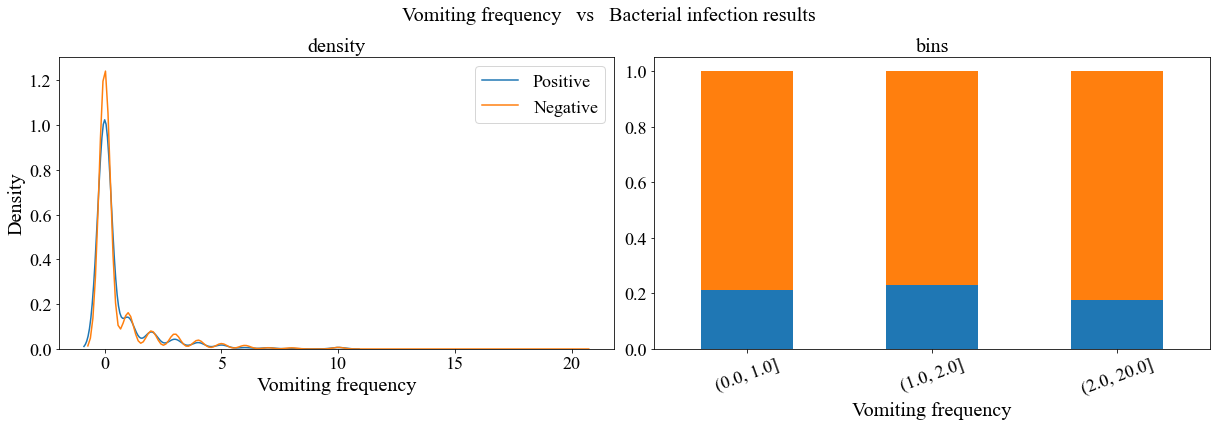

In [205]:
# 可视化
y, x = "细菌结果", "呕吐频次"
fig, ax = plt.subplots(nrows=1,
                       ncols=2,
                       sharex=False,
                       sharey=False,
                       figsize=(17, 6))



#设置图例并且设置图例的字体及大小
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 18,
}

#设置横纵坐标的名称以及对应字体格式
font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 20,
}

font3 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 23,
}

fig.suptitle("Vomiting frequency" + "   vs   " + "Bacterial infection results",fontsize=20,fontproperties=font3)

### distribution
ax[0].set_title('density',fontproperties=font2)
# i = 0 or 1
# 分别对两类标签画出年龄分布图
for i in df[y].unique():
    sns.distplot(df[df[y] == i][x], hist=False, label="Negative" if i==0 else "Positive", ax=ax[0])
# ax[0].grid(True)
ax[0].legend(prop=font1,loc='best')
ax[0].set_xlabel('Vomiting frequency',font2)
ax[0].set_ylabel('Density',font2)

#设置坐标刻度值的大小以及刻度值的字体
ax[0].tick_params(labelsize=18)
labels = ax[0].get_xticklabels() + ax[0].get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]

### stacked

ax[1].set_title('bins',fontproperties=font2)
# numpy.linspace(start, stop, num=11) 
# numpy.quantile(a, q): 其中 q 代表要计算的分位数序列,取值在(0,1)
breaks = np.quantile(df[x], q=np.linspace(0, 1, 11))
# pd.cut(): 将值转换为离散的间隔,也可以将连续变量转换为分类变量
# df.groupby([y, pd.cut()]).size(): 根据细菌结果和不同年龄段两个因素进行分组,并计算每组的数量
# unstack 之后, index 是细菌结果, columns 是每一个分组
# 再转置一下就是把 index 和 columns 互换位置
tmp = df.groupby([y, pd.cut(df[x], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[df[y].unique()]
# .sum(axis=1): 将 tmp 表中每一行的值相加求和
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
    # 求比例
    tmp[col] = tmp[col] / tmp["tot"]
# if stacked=False, 会画两个并排的柱子
tmp.drop("tot", axis=1).plot(kind='bar',
                             stacked=True,
                             ax=ax[1],
                             legend=False,)
                             #grid=True)
ax[1].set_xlabel('Vomiting frequency',font2)
plt.xticks(rotation=20)


ax[1].tick_params(labelsize=18)
labels = ax[1].get_xticklabels() + ax[1].get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]


# ### boxplot
# # outliers: 离群值
# ax[2].title.set_text('outliers')
# sns.boxplot(x=y, y=x, data=df, width=0.3, ax=ax[2])
# ax[2].grid(True)

# 调整整体空白
fig.tight_layout()
plt.show();

fig.savefig('D:/Dropbox/论文/图片/Vomiting frequency_vs_label.pdf',bbox_inches = 'tight')

#ax.figure.savefig('D:/Dropbox/论文/图片/age.pdf',bbox_inches = 'tight')

In [195]:
## 分类数据：卡方检验
def correlation_chi2(x,y,df):
    """
    Chi-Square test: for two categorical factors
    """
    cont_table = pd.crosstab(index=df[x], columns=df[y])
    chi2_test = scipy.stats.chi2_contingency(cont_table)
    chi2, p = chi2_test[0], chi2_test[1]
    n = cont_table.sum().sum()
    phi2 = chi2/n
    r,k = cont_table.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    coeff = np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))
    coeff, p = round(coeff, 3), round(p, 3)
    conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
#     conclusion = "Significant" if p < 0.05 else "Non-Significant"
    print("Cramer Correlation:", coeff, conclusion, "(p-value:"+str(p)+")")
    return coeff, p, conclusion
    
y = "细菌结果"
obj_coeff = []
obj_p = []
obj_conclusion = []
for column in obj_columns:
    coeff, p, conclusion = correlation_chi2(column,y,df)
    obj_coeff.append(coeff)
    obj_p.append(p)
    obj_conclusion.append(conclusion)


list_of_tuple = list(zip(obj_coeff,obj_p,obj_conclusion))
obj_result = pd.DataFrame(data=list_of_tuple,index=obj_columns,columns=["Coeff", "P Value", "Effective"])
# 设置让列名对齐
obj_result.style.set_properties(**{'text-align': 'left'})

Cramer Correlation: 0.431 Correlated (p-value:0.0)
Cramer Correlation: 0.035 Correlated (p-value:0.0)
Cramer Correlation: 0.119 Correlated (p-value:0.0)
Cramer Correlation: 0.144 Correlated (p-value:0.0)
Cramer Correlation: 0.062 Correlated (p-value:0.0)
Cramer Correlation: 0.101 Correlated (p-value:0.0)
Cramer Correlation: 0.013 Non-Correlated (p-value:0.136)
Cramer Correlation: 0.019 Correlated (p-value:0.025)
Cramer Correlation: 0.028 Correlated (p-value:0.001)
Cramer Correlation: 0.006 Non-Correlated (p-value:0.237)
Cramer Correlation: 0.015 Non-Correlated (p-value:0.054)
Cramer Correlation: 0.115 Correlated (p-value:0.0)
Cramer Correlation: 0.118 Correlated (p-value:0.0)
Cramer Correlation: 0.136 Correlated (p-value:0.0)
Cramer Correlation: 0.0 Non-Correlated (p-value:0.641)
Cramer Correlation: 0.087 Correlated (p-value:0.0)
Cramer Correlation: 0.02 Correlated (p-value:0.019)
Cramer Correlation: 0.074 Correlated (p-value:0.0)
Cramer Correlation: 0.0 Non-Correlated (p-value:0.951)


,Coeff,P Value,Effective
区县,0.431000,0.000000,Correlated
性别,0.035000,0.000000,Correlated
户籍,0.119000,0.000000,Correlated
职业,0.144000,0.000000,Correlated
首发症状,0.062000,0.000000,Correlated
发热,0.101000,0.000000,Correlated
脱水,0.013000,0.136000,Non-Correlated
腹胀,0.019000,0.025000,Correlated
恶心,0.028000,0.001000,Correlated
里急后重,0.006000,0.237000,Non-Correlated


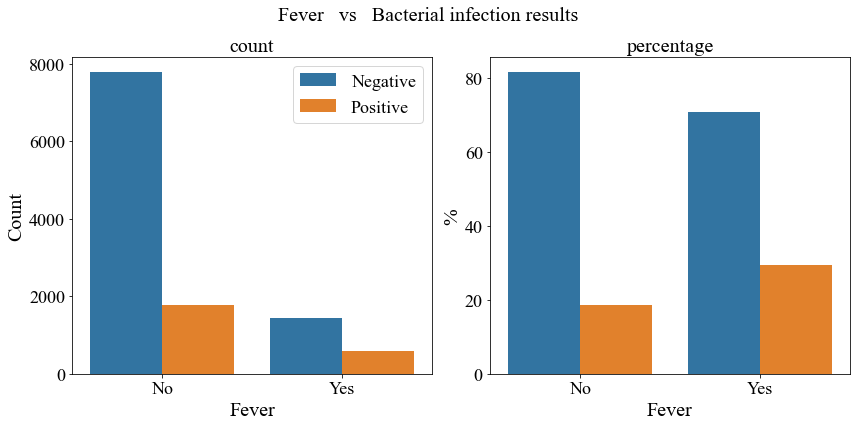

In [216]:
#设置图例并且设置图例的字体及大小
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 18,
}

#设置横纵坐标的名称以及对应字体格式
font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 20,
}

font3 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 23,
}


def correlation_plot(x,y,df):
    fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False, figsize=(12, 6))
    fig.suptitle("Fever"+"   vs   "+"Bacterial infection results", fontsize=20,fontproperties=font3)

    ### count
    ax[0].set_title('count',fontproperties=font2)
    # groupby(x) 括号中填写的是 column, 这个 column 就会变为分组表中的 index
    # groupby(x)[y]: y 会成为分组表中的 column
    order = df.groupby(x)[y].count().index.tolist()
    # order =  ["男", "女"]
    # sns.countplot: x 是横轴, count 是纵轴, hue 是分组
    sns.countplot(x=x, hue=y, data=df, order=order, ax=ax[0])
    # ax[0].grid(True)
    ax[0].legend(prop=font1,loc='best',labels=['Negative', 'Positive'])
    
    ax[0].set_xlabel('Fever',font2)
    ax[0].set_ylabel('Count',font2)
    ax[0].set_xticklabels(['No','Yes'])
    #设置坐标刻度值的大小以及刻度值的字体
    ax[0].tick_params(labelsize=18)
    labels = ax[0].get_xticklabels() + ax[0].get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    
    ### percentage
    ax[1].set_title('percentage',fontproperties=font2)
    # reset_index(): 本来在分组表中是 x ("性别") 作为 index
    # 此时使用 reset_index() 就是将性别这个索引还原为原来的列
    # groupby 之后考虑是否要 reset_index()
    a = df.groupby(x)[y].count().reset_index()
    # 把 column 为 y ("细菌结果") 的列重命名为: "tot" (total)
    a = a.rename(columns={y:"tot"})
    # 注意 b 是 Series 结构，不是 DataFrame
    b = df.groupby([x,y])[y].count()
    # 把 b 从 Series 转换为 DataFrame
    b = b.to_frame()
    b = b.rename(columns={y:0}).reset_index()
    b = b.merge(a, how="left")
    b["%"] = b[0] / b["tot"] *100
    sns.barplot(x=x, y="%", hue=y, data=b,
                ax=ax[1]).get_legend().remove()
    # ax[1].grid(True)
    ax[1].set_xticklabels(['No','Yes'])
    ax[1].set_xlabel('Fever',font2)
    ax[1].set_ylabel('%',font2)
    ax[1].tick_params(labelsize=18)
    labels = ax[1].get_xticklabels() + ax[1].get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    # 调整整体空白
    fig.tight_layout()
    plt.show();
    fig.savefig('D:/Dropbox/论文/图片/fever_vs_label.pdf',bbox_inches = 'tight')

# 有显著影响的特征
x, y = "发热", "细菌结果"
correlation_plot(x,y,df)

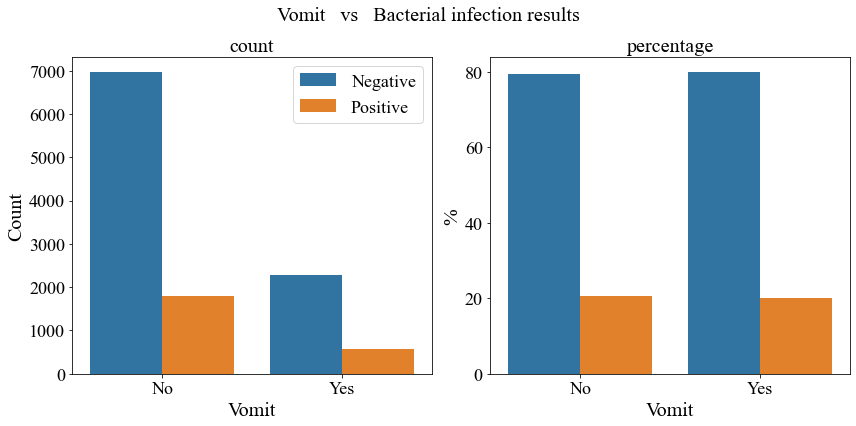

In [217]:
def correlation_plot_1(x,y,df):
    fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False, figsize=(12, 6))
    fig.suptitle("Vomit"+"   vs   "+"Bacterial infection results", fontsize=20,fontproperties=font3)

    ### count
    ax[0].set_title('count',fontproperties=font2)
    # groupby(x) 括号中填写的是 column, 这个 column 就会变为分组表中的 index
    # groupby(x)[y]: y 会成为分组表中的 column
    order = df.groupby(x)[y].count().index.tolist()
    # order =  ["男", "女"]
    # sns.countplot: x 是横轴, count 是纵轴, hue 是分组
    sns.countplot(x=x, hue=y, data=df, order=order, ax=ax[0])
    # ax[0].grid(True)
    ax[0].legend(prop=font1,loc='best',labels=['Negative', 'Positive'])
    ax[0].set_xlabel('Vomit',font2)
    ax[0].set_ylabel('Count',font2)
    ax[0].set_xticklabels(['No','Yes'])
    #设置坐标刻度值的大小以及刻度值的字体
    ax[0].tick_params(labelsize=18)
    labels = ax[0].get_xticklabels() + ax[0].get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    
    ### percentage
    ax[1].set_title('percentage',fontproperties=font2)
    # reset_index(): 本来在分组表中是 x ("性别") 作为 index
    # 此时使用 reset_index() 就是将性别这个索引还原为原来的列
    # groupby 之后考虑是否要 reset_index()
    a = df.groupby(x)[y].count().reset_index()
    # 把 column 为 y ("细菌结果") 的列重命名为: "tot" (total)
    a = a.rename(columns={y:"tot"})
    # 注意 b 是 Series 结构，不是 DataFrame
    b = df.groupby([x,y])[y].count()
    # 把 b 从 Series 转换为 DataFrame
    b = b.to_frame()
    b = b.rename(columns={y:0}).reset_index()
    b = b.merge(a, how="left")
    b["%"] = b[0] / b["tot"] *100
    sns.barplot(x=x, y="%", hue=y, data=b,
                ax=ax[1]).get_legend().remove()
    # ax[1].grid(True)
    ax[1].set_xticklabels(['No','Yes'])
    ax[1].set_xlabel('Vomit',font2)
    ax[1].set_ylabel('%',font2)
    ax[1].tick_params(labelsize=18)
    labels = ax[1].get_xticklabels() + ax[1].get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    # 调整整体空白
    fig.tight_layout()
    plt.show();
    fig.savefig('D:/Dropbox/论文/图片/Vomit_vs_label.pdf',bbox_inches = 'tight')


# 无显著影响的特征
x, y = "呕吐", "细菌结果"
correlation_plot_1(x,y,df)

In [218]:
obj_result = obj_result.drop(columns=['Coeff'],axis=1)

In [258]:
#### 注意这里，可以和不提取特征做比较
# 把有显著性影响的特征值取出来，用于后续的分析
# cont_result & obj_result
cont_obj_result = pd.concat([cont_result,obj_result])
cont_obj_result
final_columns = cont_obj_result[cont_obj_result["Effective"]=="Correlated"].index.to_list()
final_columns

# 把无关的列都删除
df = df[final_columns]
df

,P Value,Effective
age,0.000,Correlated
体温,0.000,Correlated
呕吐频次,0.116,Non-Correlated
持续天数,0.234,Non-Correlated
腹泻量,0.000,Correlated
腹泻频次,0.000,Correlated
腹泻天数,0.000,Correlated
疑似病例人数,0.564,Non-Correlated
细菌结果,0.000,Correlated
区县,0.000,Correlated


['age',
 '体温',
 '腹泻量',
 '腹泻频次',
 '腹泻天数',
 '细菌结果',
 '区县',
 '性别',
 '户籍',
 '职业',
 '首发症状',
 '发热',
 '腹胀',
 '恶心',
 '腹痛',
 '腹痛性质',
 '腹痛部位',
 '呕吐在腹泻___发生',
 '腹泻',
 '腹泻性质',
 '近6个月有无肠道疾病既往史',
 '食品名称',
 '食物分类',
 '进餐地点',
 '是否家中饲养或接触过宠物',
 '就诊前是否服用过抗生素',
 '诊断',
 '诊断类型',
 '临床处理',
 '本次就诊是否给予抗生素',
 '抗生素名称.1',
 '是否采集',
 '采样类型']

,age,体温,腹泻量,腹泻频次,腹泻天数,细菌结果,区县,性别,户籍,职业,...,进餐地点,是否家中饲养或接触过宠物,就诊前是否服用过抗生素,诊断,诊断类型,临床处理,本次就诊是否给予抗生素,抗生素名称.1,是否采集,采样类型
1,59,38.0,2.0,5.0,2.0,1,闵行区,Male,本市外来（含港澳台）,医务人员,...,食堂,无,无,胃肠炎,实验室诊断,无,无,无,有,食源性采样
8,36,37.0,3.0,3.0,1.0,0,闵行区,Female,本市常住,商业服务,...,家庭,无,无,急性胃肠炎,临床诊断,口服用药,有,头孢夫辛,有,食源性采样
9,36,38.0,2.0,3.0,2.0,1,闵行区,Female,本市常住,工人,...,餐饮店,无,无,肠功能紊乱,临床诊断,口服用药,无,无,有,食源性采样
11,27,38.0,2.0,2.0,3.0,0,闵行区,Female,本市常住,不详,...,家庭,无,无,肠道功能紊乱,无,口服用药,有,其他(黄连素),有,腹泻病采样
12,77,37.0,2.0,3.0,2.0,0,闵行区,Female,本市常住,离退人员,...,家庭,无,无,肠功能紊乱,临床诊断,口服用药,无,无,有,食源性采样
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38139,60,38.0,2.0,8.0,1.0,1,青浦区,Female,本市常住,离退人员,...,无,无,无,急性肠炎,临床诊断,口服用药,有,左氧氟沙星,有,"腹泻病采样,平行样采样"
38149,33,38.0,2.0,10.0,1.0,0,松江区,Male,流动人口（含港澳台）,干部职员,...,无,无,无,急性胃肠炎,无,口服用药,有,左氧氟沙星,有,"腹泻病采样,平行样采样"
38153,35,38.8,2.0,9.0,1.0,1,松江区,Male,流动人口（含港澳台）,干部职员,...,家庭,无,无,急性胃肠炎,无,无,有,"头孢夫辛,左氧氟沙星",有,食源性采样
38156,69,38.0,2.0,4.0,1.0,1,青浦区,Male,本市常住,离退人员,...,家庭,无,无,急性肠炎,无,输液,有,"头孢夫辛,左氧氟沙星",有,腹泻病采样


### 分类数据编码


In [259]:
# 为简单起见，还是先用 one-hot 编码试试看

# 8.18 更新：好像可以直接按下面处理，会自动将分类数据列转换为 one-hot，连续数据列不变
# df=pd.get_dummies(df)

## 分类数据编码：病例类型
def cat2int(x, df):
    # pandas 实现 one hot encode
    dummy = pd.get_dummies(df[x], prefix=x, drop_first=True)
    df = pd.concat([df, dummy], axis=1)
    # print(df.filter(like=x, axis=1).head())
    
    ## drop the original categorical column
    return df.drop(x, axis=1)
    
# 重建索引
df = df.reset_index()

In [260]:
# 选出所有类型为 object 的列
# 下面这两个 column 的类别太多太杂了，暂时不考虑
del_col = ["食品名称","食物分类"]
columns = [column for column in df.select_dtypes(include=object).columns if column not in del_col]
for column in columns:
    print(column)
    # 这里居然有一个迭代！
    df = cat2int(column, df)
    
df.head()
# 居然转换出了 3006 个特征...

# 删除那两项后特征数量减少到了 386，很好

## 8.17 更新
# 删除无关特征后，特征数量减少到了 361

区县
性别
户籍
职业
首发症状
发热
腹胀
恶心
腹痛
腹痛性质
腹痛部位
呕吐在腹泻___发生
腹泻
腹泻性质
近6个月有无肠道疾病既往史
进餐地点
是否家中饲养或接触过宠物
就诊前是否服用过抗生素
诊断
诊断类型
临床处理
本次就诊是否给予抗生素
抗生素名称.1
是否采集
采样类型


,index,age,体温,腹泻量,腹泻频次,腹泻天数,细菌结果,食品名称,食物分类,区县_奉贤区,...,是否采集_有,采样类型_未采样,采样类型_未采样 平行样采样,采样类型_腹泻病采样,采样类型_腹泻病采样 平行样采样,"采样类型_腹泻病采样,其他采样","采样类型_腹泻病采样,平行样采样","采样类型_腹泻病采样,平行样采样,其他采样",采样类型_食源性采样,"采样类型_食源性采样,其他采样"
0,1,59,38.0,2.0,5.0,2.0,1,红烧肉,肉与肉制品,0,...,1,0,0,0,0,0,0,0,1,0
1,8,36,37.0,3.0,3.0,1.0,0,酸奶,乳与乳制品,0,...,1,0,0,0,0,0,0,0,1,0
2,9,36,38.0,2.0,3.0,2.0,1,红烧肉,肉与肉制品,0,...,1,0,0,0,0,0,0,0,1,0
3,11,27,38.0,2.0,2.0,3.0,0,猪肉,肉与肉制品,0,...,1,0,0,1,0,0,0,0,0,0
4,12,77,37.0,2.0,3.0,2.0,0,牛奶,乳与乳制品,0,...,1,0,0,0,0,0,0,0,1,0


### 随机森林自动选择特征


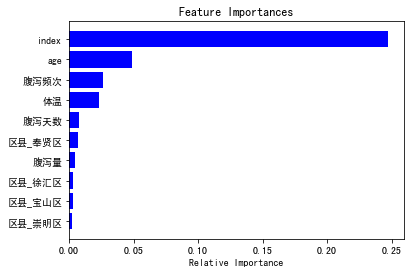

In [137]:
from sklearn.ensemble import RandomForestRegressor
df_feature = df.drop(['细菌结果',"食品名称","食物分类"],1)
model = RandomForestRegressor(random_state=1, max_depth=10)
model.fit(df_feature,df['细菌结果'])

# 拟合模型后，根据特征的重要性绘制成图：
features = df_feature.columns
importances = model.feature_importances_
indices = np.argsort(importances[0:10])  # top 30 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show();

# 类别太多了好像意义不大

## 数据集划分


In [261]:
## 数据集 分层抽样
# 因为将来会采用 K 折交叉验证，所以此处不用划分出验证集
y = '细菌结果'
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df,test_size=0.3, 
                     stratify=df[y], random_state=42)

## print info
print("X_train shape:", df_train.drop(y,axis=1).shape, "| X_test shape:", df_test.drop(y,axis=1).shape)
print("y_train mean:", round(np.mean(df_train[y]),2), "| y_test mean:", round(np.mean(df_test[y]),2))
print(df_train.shape[1], "features:", df_train.drop(y,axis=1).columns.to_list())
print('-'*50)

## 查看各个类别的比例
print("训练集：")
print(df_train[y].value_counts() / len(df_train[y]))
print("测试集：")
print(df_test[y].value_counts() / len(df_test[y]))
# 比例很平衡，不用做综合采样了

X_train shape: (8120, 360) | X_test shape: (3480, 360)
y_train mean: 0.2 | y_test mean: 0.2
361 features: ['index', 'age', '体温', '腹泻量', '腹泻频次', '腹泻天数', '食品名称', '食物分类', '区县_奉贤区', '区县_宝山区', '区县_崇明区', '区县_徐汇区', '区县_普陀区', '区县_杨浦区', '区县_松江区', '区县_浦东新区', '区县_虹口区', '区县_金山区', '区县_长宁区', '区县_闵行区', '区县_闸北区', '区县_青浦区', '区县_静安区', '区县_黄浦区', '性别_Male', '户籍_本市外来（含港澳台）', '户籍_本市常住', '户籍_流动人口', '户籍_流动人口（含港澳台）', '职业_中小学生', '职业_保育员及保姆', '职业_公共场所服务员', '职业_其他', '职业_其他学生', '职业_农民', '职业_医务人员', '职业_商业服务', '职业_学生', '职业_家务及待业', '职业_工人', '职业_干部职员', '职业_教师', '职业_散居儿童', '职业_无', '职业_民工', '职业_海员及长途驾驶员', '职业_渔(船)民', '职业_渔（船）民', '职业_离退人员', '职业_餐饮食品业', '首发症状_发热', '首发症状_发热,腹泻', '首发症状_发热,腹泻,呕吐', '首发症状_发热,腹痛', '首发症状_发热,腹痛,呕吐', '首发症状_发热,腹痛,腹泻', '首发症状_发热,腹痛,腹泻,呕吐', '首发症状_呕吐', '首发症状_无', '首发症状_腹泻', '首发症状_腹泻,呕吐', '首发症状_腹痛', '首发症状_腹痛,呕吐', '首发症状_腹痛,腹泻', '首发症状_腹痛,腹泻,呕吐', '发热_有', '腹胀_有', '恶心_有', '腹痛_有', '腹痛性质_无', '腹痛性质_阵发性', '腹痛部位_右上,右下', '腹痛部位_右上,脐周', '腹痛部位_右下', '腹痛部位_右下,脐周', '腹痛部位_左上', '腹痛部位_左上 右上', '腹痛部位_左上 右上 脐周', '腹痛部位_左上 右下', 

In [262]:
# 查看数据类型
df.dtypes
df.select_dtypes(include=object).columns

index                      int64
age                        int64
体温                       float64
腹泻量                      float64
腹泻频次                     float64
                          ...   
采样类型_腹泻病采样,其他采样            uint8
采样类型_腹泻病采样,平行样采样           uint8
采样类型_腹泻病采样,平行样采样,其他采样      uint8
采样类型_食源性采样                 uint8
采样类型_食源性采样,其他采样            uint8
Length: 361, dtype: object

Index(['食品名称', '食物分类'], dtype='object')

In [263]:
label = '细菌结果'
features = [column for column in df.columns if column != label and column not in del_col]
X_train = df_train[features]
y_train = df_train[label]

X_test = df_test[features]
y_test = df_test[label]

# Model Design
## Logistic Regression

In [264]:
### ------------------基本的分类器---------------------
## 逻辑回归

from sklearn.linear_model import LogisticRegression
# 或者使用 class_weight={0:0.1,1:0.9}
# 如果取值 class_weight='balanced'，则类库会依据样本量来计算权重。
# 某种类型的样本量越多，则权重越低；样本量越少，则权重越高。
# 其实这里的调节权重和调节阈值原理非常类似
model = LogisticRegression(class_weight='balanced')

## define hyperparameters combinations to try
param_dic = {'penalty':['l2', 'l1'],      
'C':[0.01,1,10],           
'solver':['liblinear','lbfgs','newton-cg','sag'],
'max_iter': [50,100]}       

## random search
random_search = model_selection.RandomizedSearchCV(model, 
       param_distributions=param_dic, n_iter=1000, cv=10,
       scoring="f1").fit(X_train, y_train)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean f1:", random_search.best_score_)
model = random_search.best_estimator_

Best Model parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 50, 'C': 1}
Best Model mean f1: 0.47233539539758274


In [ ]:
## LR：逻辑回归
# model = LogisticRegression(class_weight='balanced', solver='newton-cg',penalty='l2',max_iter=50, C=1)

In [297]:
## Naive Bayes
# from sklearn.naive_bayes import BernoulliNB
# model = BernoulliNB()

In [306]:
## Random Forest

# model = ensemble.RandomForestClassifier(random_state=10)

In [313]:
## Gradient Boosting Classifier
model = ensemble.GradientBoostingClassifier(random_state=0)

## PCA 进行无监督降维操作，逻辑回归进行分类

In [ ]:
## 做比较的时候跳过这一步
## Define a pipeline to search for the best combination of PCA truncation
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# model = LogisticRegression(class_weight='balanced', solver='newton-cg',
#                            penalty='l2',max_iter=50, C=1)

In [314]:
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', model)])
# Parameters of pipelines can be set using '_' separated parameter names
param_grid = {
#     'pca__n_components': [5, 20, 30, 40, 50, 64,100,128,200,256,300],
    'pca__n_components': [128,200,256,300],
}

## search
search = GridSearchCV(pipe, param_grid, cv=5,
       scoring="f1").fit(X_train, y_train)
print("Best Model parameters:", search.best_params_)
print("Best Model mean f1:", search.best_score_)
pipe = search.best_estimator_

Best Model parameters: {'pca__n_components': 200}
Best Model mean f1: 0.3564144534229273


In [ ]:
# plot the pca spectrum


# Evaluation

In [265]:
def train(X, y, model):
    model.fit(X, y)

In [266]:
## Evaluation
def eval(X_test, y_test, predicted, predicted_prob, model):
    
    ## Accuray e AUC
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted_prob)
    print("Accuracy (overall correct predictions):",  round(accuracy,2))
    print("Auc:", round(auc,2))

    ## Precision e Recall
    recall = metrics.recall_score(y_test, predicted)
    precision = metrics.precision_score(y_test, predicted)
    print("Recall (all 1s predicted right):", round(recall,2))
    print("Precision (confidence when predicting a 1):", round(precision,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in np.unique(y_test)]))
    
    ## confusion matrix
    classes = np.unique(y_test)
    fig, ax = plt.subplots(figsize=(7,5))
    cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
    ax.set_yticklabels(labels=classes, rotation=0)
    plt.tight_layout()
    plt.show();
    
    return recall, precision, cm

Pipeline(steps=[('pca', PCA(n_components=200)),
                ('logistic', GradientBoostingClassifier(random_state=0))])
[[0.26805137 0.73194863]
 [0.86164659 0.13835341]
 [0.90257632 0.09742368]
 ...
 [0.8753045  0.1246955 ]
 [0.98451431 0.01548569]
 [0.75292941 0.24707059]]
Accuracy (overall correct predictions): 0.83
Auc: 0.78
Recall (all 1s predicted right): 0.22
Precision (confidence when predicting a 1): 0.85
Detail:
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      2769
           1       0.85      0.22      0.35       711

    accuracy                           0.83      3480
   macro avg       0.84      0.60      0.63      3480
weighted avg       0.83      0.83      0.79      3480



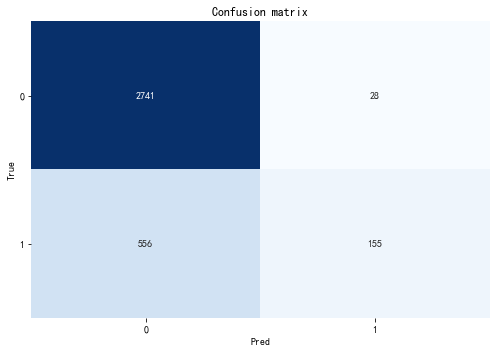

In [315]:
## 如果使用 pipe: PCA + logistic
model = pipe
print(model)

### 在整个训练集上训练模型
## train
train(X_train, y_train, model)

## test
# 第二列是样本预测为 1 的概率
predicted_prob = model.predict_proba(X_test)[:,1] 
print(model.predict_proba(X_test))
predicted = model.predict(X_test)

recall, precision, cm = eval(X_test, y_test, predicted, predicted_prob, model)

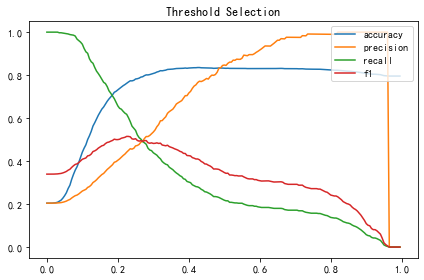

In [316]:
## calculate scores for different thresholds
dic_scores = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}
thresholds = []
for threshold in np.arange(0, 1, step=0.005):
    predicted = (predicted_prob > threshold)
    thresholds.append(threshold)
    dic_scores["accuracy"].append(metrics.accuracy_score(y_test, predicted))
    dic_scores["precision"].append(metrics.precision_score(y_test, predicted))
    dic_scores["recall"].append(metrics.recall_score(y_test, predicted))
    dic_scores["f1"].append(metrics.f1_score(y_test, predicted))
        
## plot
df_scores = pd.DataFrame(dic_scores).set_index(pd.Index(thresholds))    
df_scores.plot(title="Threshold Selection")
plt.tight_layout()
plt.legend(loc="upper right")
plt.show();

Accuracy (overall correct predictions): 0.68
Auc: 0.78
Recall (all 1s predicted right): 0.75
Precision (confidence when predicting a 1): 0.36
Detail:
              precision    recall  f1-score   support

           0       0.91      0.66      0.77      2769
           1       0.36      0.75      0.49       711

    accuracy                           0.68      3480
   macro avg       0.64      0.70      0.63      3480
weighted avg       0.80      0.68      0.71      3480



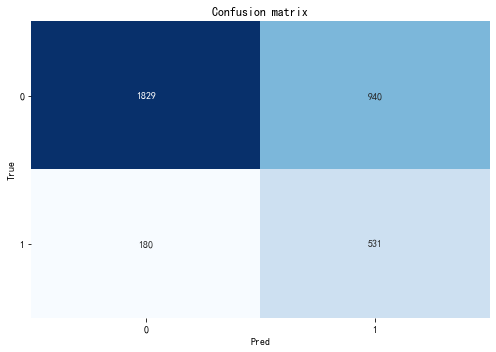

In [318]:
threshold = 0.17
predicted_prob = model.predict_proba(X_test)[:,1] 
predicted = (predicted_prob > threshold)
# predicted = model.predict(X_test)

recall, precision, cm = eval(X_test, y_test, predicted, predicted_prob, model)

In [35]:
# 输出每个类别的概率
# classes = np.unique(y_test)
# print(classes)
print(model.classes_) #此为概率对应类别
predicted_prob = model.predict_proba(X_test)
predicted_prob

[0 1]


array([[0.1157832 , 0.8842168 ],
       [0.78619702, 0.21380298],
       [0.8682829 , 0.1317171 ],
       ...,
       [0.92990607, 0.07009393],
       [0.92515445, 0.07484555],
       [0.41064151, 0.58935849]])

In [36]:
probability = pd.DataFrame({model.classes_[0]: predicted_prob[:,0],
                           model.classes_[1]: predicted_prob[:,1]})
probability

,0,1
0,0.115783,0.884217
1,0.786197,0.213803
2,0.868283,0.131717
3,0.768242,0.231758
4,0.551774,0.448226
...,...,...
3475,0.331960,0.668040
3476,0.879895,0.120105
3477,0.929906,0.070094
3478,0.925154,0.074846
